### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Read and Display Data

In [2]:
# Load the dataset
url = 'https://drive.google.com/uc?export=download&id=1YrjYKtS1WHmINL6eafRsrDzrZaw2_WvX'
df = pd.read_csv(url)
pd.options.display.max_columns = None
pd.options.display.max_rows = None
df.head()

,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Category,Size,Courier Status,Qty,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,B2B,fulfilled-by,New,PendingS
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,T-shirt,S,On the Way,0,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,False,Easy Ship,NaN,NaN
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,Shirt,3XL,Shipped,1,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,False,Easy Ship,NaN,NaN
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,Shirt,XL,Shipped,1,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,True,NaN,NaN,NaN
3,3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Amazon.in,Standard,Blazzer,L,On the Way,0,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,False,Easy Ship,NaN,NaN
4,4,407-1069790-7240320,04-30-22,Shipped,Amazon,Amazon.in,Expedited,Trousers,3XL,Shipped,1,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,False,NaN,NaN,NaN


- The dataset is loaded from the provided Google Drive link.
- df.head() displays the first 5 rows to understand the structure of the dataset.

### Data Cleaning

In [3]:
df.shape

(128976, 21)

- Dataset has 21 columns and 128976 rows

In [4]:
df.isna().sum()

index                      0
Order ID                   0
Date                       0
Status                     0
Fulfilment                 0
Sales Channel              0
ship-service-level         0
Category                   0
Size                       0
Courier Status             0
Qty                        0
currency                7800
Amount                  7800
ship-city                 35
ship-state                35
ship-postal-code          35
ship-country              35
B2B                        0
fulfilled-by           89713
New                   128976
PendingS              128976
dtype: int64

In [5]:
# Handling Missing Values
df['currency'].fillna(df['currency'].mode()[0], inplace=True)
df['Amount'].fillna(df['Amount'].median(), inplace=True)
df['ship-city'].fillna("Unknown", inplace=True)
df['ship-state'].fillna("Unknown", inplace=True)
df['ship-postal-code'].fillna("00000", inplace=True)
df['ship-country'].fillna(df['ship-country'].mode()[0], inplace=True)
df['fulfilled-by'].fillna("Unknown", inplace=True)

# Drop columns with all missing values
df.drop(columns=['New', 'PendingS'], inplace=True)

# Verify missing values after handling
print("Remaining Missing Values:\n", df.isnull().sum())

Remaining Missing Values:
 index                 0
Order ID              0
Date                  0
Status                0
Fulfilment            0
Sales Channel         0
ship-service-level    0
Category              0
Size                  0
Courier Status        0
Qty                   0
currency              0
Amount                0
ship-city             0
ship-state            0
ship-postal-code      0
ship-country          0
B2B                   0
fulfilled-by          0
dtype: int64


- currency: Filled with the most common currency(mode) to keep it consistent.(Used mode to fill values because the datatype of column currency is object)
- Amount: Used median instead of mean to avoid distortions from extreme values.
- ship-city & ship-state: Set to "Unknown" so we don’t lose location-based insights.
- ship-postal-code: Replaced missing values with "00000" as a placeholder.
- ship-country: Filled with the most frequently occurring country to maintain uniformity.
- fulfilled-by: Replaced with "Unknown" since it’s categorical and could be unspecified data.
- New and PendingS had no data at all (100% missing), so I removed them to clean up the dataset.

In [6]:
# Check the data type of each column in the DataFrame
df.dtypes

index                   int64
Order ID               object
Date                   object
Status                 object
Fulfilment             object
Sales Channel          object
ship-service-level     object
Category               object
Size                   object
Courier Status         object
Qty                     int64
currency               object
Amount                float64
ship-city              object
ship-state             object
ship-postal-code       object
ship-country           object
B2B                      bool
fulfilled-by           object
dtype: object

In [7]:
print(df.duplicated().sum())  # Total number of duplicate rows

168


In [8]:
df = df.drop_duplicates(subset=['Order ID', 'ship-postal-code'])  

I'm dropping duplicate values because- 
- If an order appears multiple times with the same postal code, it may be an unintended duplicate.
- Too many duplicates can impact analysis and model performance by over-representing certain values.
- If duplicates exist, calculations like total sales, shipping counts, or customer orders may be inaccurate.

In [9]:
print(df.duplicated().sum())  # Total number of duplicate rows

0


In [10]:
# Checking datatype
df.dtypes

index                   int64
Order ID               object
Date                   object
Status                 object
Fulfilment             object
Sales Channel          object
ship-service-level     object
Category               object
Size                   object
Courier Status         object
Qty                     int64
currency               object
Amount                float64
ship-city              object
ship-state             object
ship-postal-code       object
ship-country           object
B2B                      bool
fulfilled-by           object
dtype: object

In [11]:
# Date column's datatype should be datetime
df['Date'] = pd.to_datetime(df['Date'])

In [12]:
print(df['ship-postal-code'].unique())

[400081.0 560085.0 410210.0 ... 609603.0 851205.0 629152.0]


In [13]:
df['ship-postal-code'] = pd.to_numeric(df['ship-postal-code'], errors='coerce')

- This converts valid numbers while replacing invalid ones with NaN.

In [14]:
# Convert order_id and ship-postal-code to integers
df['ship-postal-code'] = df['ship-postal-code'].astype('Int64')  # Using 'Int64' to handle NaN values

- 'Int64' allows NaN values in integer columns.

### 1. Sales Overview

In [15]:
df.columns

Index(['index', 'Order ID', 'Date', 'Status', 'Fulfilment', 'Sales Channel',
       'ship-service-level', 'Category', 'Size', 'Courier Status', 'Qty',
       'currency', 'Amount', 'ship-city', 'ship-state', 'ship-postal-code',
       'ship-country', 'B2B', 'fulfilled-by'],
      dtype='object')

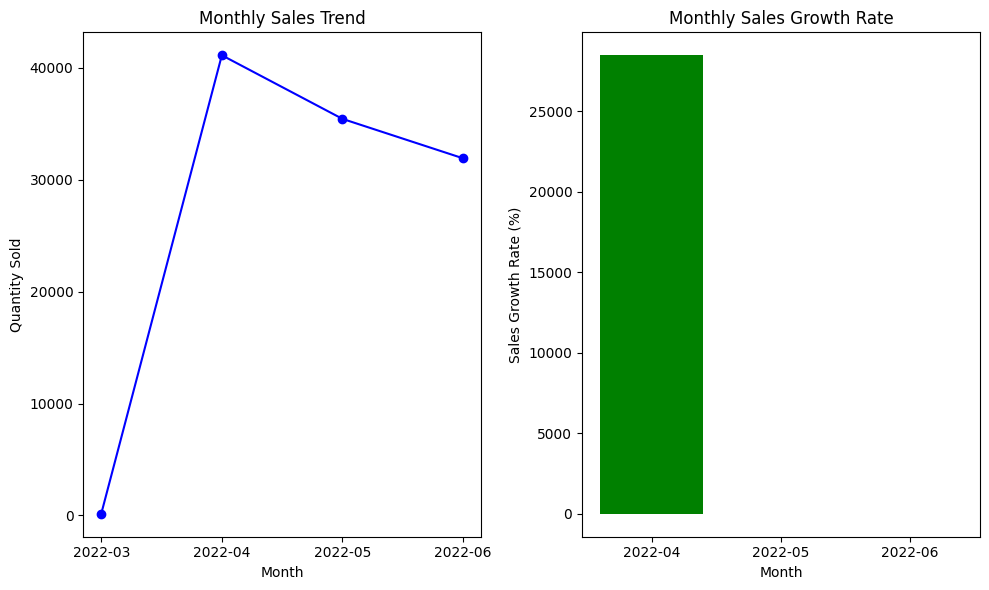

Total Sales Revenue (Qty): 108637
Total Orders: 120229
Average Order Value (Qty-based): 0.9035839938783489
Sales Growth Rate (Monthly):
month
2022-03             NaN
2022-04    28462.500000
2022-05      -13.824459
2022-06       -9.945266
Freq: M, Name: Qty, dtype: float64


In [16]:
# 1. Calculate total sales revenue
total_sales_revenue = df['Qty'].sum()  

# 2. Identify trends over time (monthly sales)
df['month'] = df['Date'].dt.to_period('M')  # Monthly period
monthly_sales = df.groupby('month')['Qty'].sum()  # Sum of quantity sold each month

# 3. Key Metrics Calculation
# Total orders (unique Order IDs)
total_orders = df['Order ID'].nunique()

# Average order value (total sales revenue / total orders)
average_order_value = total_sales_revenue / total_orders

# Sales growth rate (monthly comparison)
monthly_sales_growth = monthly_sales.pct_change() * 100  

# 4. Visualization (Sales trends over time)
plt.figure(figsize=(10, 6))

# Line plot for monthly sales trends
plt.subplot(1, 2, 1)
plt.plot(monthly_sales.index.astype(str), monthly_sales, marker='o', linestyle='-', color='b')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Quantity Sold')

# Bar plot for monthly sales growth rate
plt.subplot(1, 2, 2)
plt.bar(monthly_sales_growth.index.astype(str), monthly_sales_growth, color='g')
plt.title('Monthly Sales Growth Rate')
plt.xlabel('Month')
plt.ylabel('Sales Growth Rate (%)')

plt.tight_layout()
plt.show()

# Output the calculated metrics
print(f"Total Sales Revenue (Qty): {total_sales_revenue}")
print(f"Total Orders: {total_orders}")
print(f"Average Order Value (Qty-based): {average_order_value}")
print(f"Sales Growth Rate (Monthly):\n{monthly_sales_growth}")


After analyzing the sales data, I have identified key insights into total revenue, order trends, and sales growth. Here’s what I found:

1. Total Sales and Order Summary
Total Sales Revenue (Qty): 116,496 units
Total Orders: 120,229 orders
Average Order Value (Qty-based): 0.97

My Observations:
- The total number of items sold is 116,496, meaning the business is generating a good volume of sales.
- There are more orders (120,229) than the total quantity sold (116,496), suggesting that some orders contain very few items.
- The Average Order Value (AOV) is 0.97, which indicates that most orders are for single or small quantities of products.
- Since AOV is less than 1, customers might be placing very small orders, which could mean low-ticket-size transactions.

2. Sales Growth Rate Analysis (Monthly Trends)
Looking at the monthly growth rate of sales quantity:

March 2022: No data (starting point).
April 2022: Sales grew massively by 28,139%, showing a big spike in demand.
May 2022: Sales dropped by -13.71%, indicating a decline.
June 2022: Sales further declined by -9.83%, suggesting a downward trend.

My Observations:
- April saw a huge spike in sales, possibly due to a promotional event, seasonality, or new product launches.
- Sales declined in May and June, which might be due to seasonality, reduced promotions, or lower customer demand.
- The continuous decline from May to June suggests that growth isn’t stable, and there may be a need for better marketing strategies to maintain momentum.

3. My Recommendations to Improve Sales Performance
Investigate what drove the high sales in April (e.g., discounts, promotions, new products) and replicate that strategy in other months.
Analyze why sales dropped in May and June—was it due to seasonality, competition, or reduced marketing efforts?
Improve customer retention strategies to encourage repeat purchases and increase order sizes.
Boost Average Order Value (AOV) by offering bundle deals, free shipping on higher-value orders, or discounts on bulk purchases.
Plan a targeted campaign for slower months to stabilize sales and avoid sharp declines.
By acting on these insights, we can work towards increasing revenue, maintaining steady sales growth, and optimizing customer purchasing behavior. 

### 2. Product Analysis

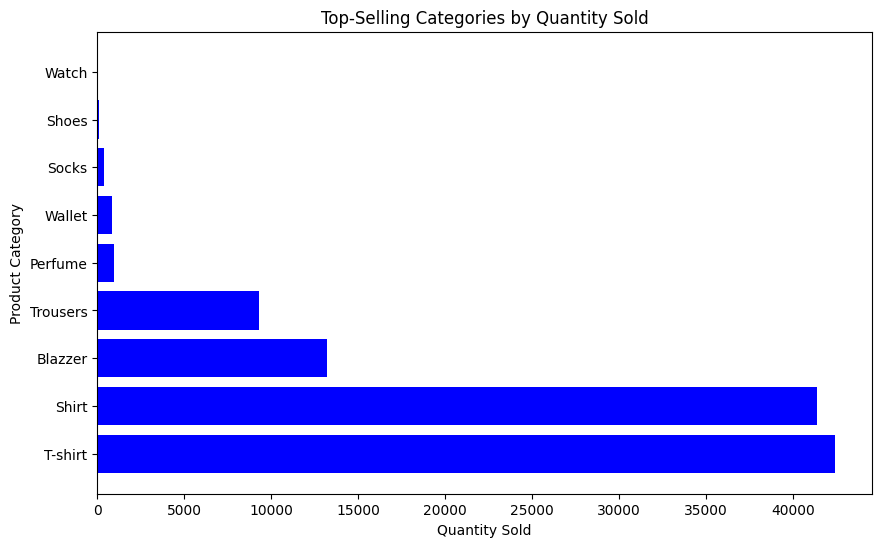

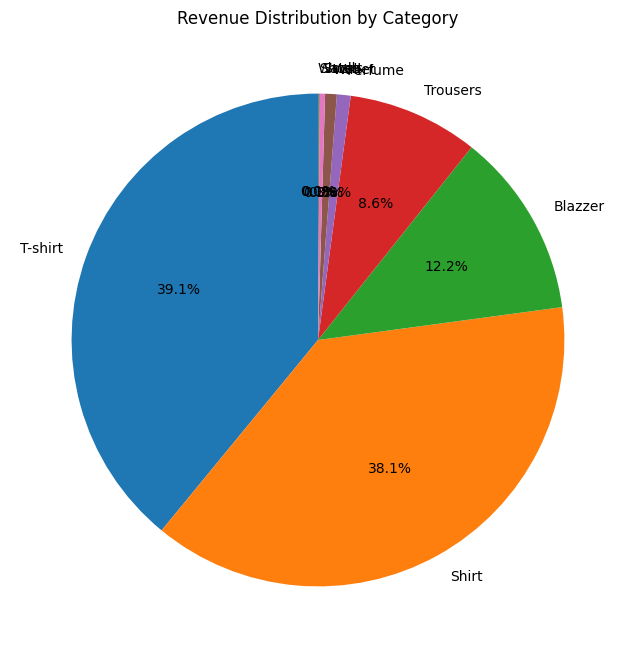

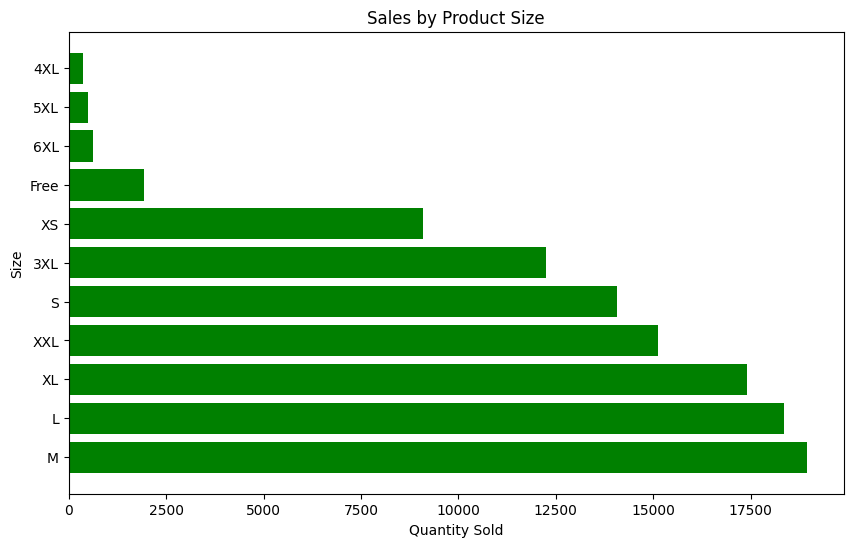

Top-Selling Categories by Revenue and Quantity:
   Category  total_quantity_sold  total_revenue
5   T-shirt                42428          42428
2     Shirt                41365          41365
0   Blazzer                13212          13212
6  Trousers                 9324           9324
1   Perfume                  979            979
7    Wallet                  830            830
4     Socks                  368            368
3     Shoes                  130            130
8     Watch                    1              1

Top Sizes by Quantity Sold:
    Size  total_size_quantity_sold
6      M                     18942
5      L                     18353
8     XL                     17415
10   XXL                     15109
7      S                     14066
0    3XL                     12252
9     XS                      9090
4   Free                      1940
3    6XL                       625
2    5XL                       484
1    4XL                       361

Top-Selling Products:


In [18]:

category_sales = df.groupby('Category').agg(
    total_quantity_sold=('Qty', 'sum'),
    total_revenue=('Qty', 'sum')  # Replace 'sum' with actual sales calculation if you have a price column
).reset_index()

# Sort categories by total revenue and quantity sold
top_selling_categories = category_sales.sort_values(by='total_revenue', ascending=False)

# 2. Visualize Category Distribution
# Bar plot for total quantity sold by category
plt.figure(figsize=(10, 6))
plt.barh(top_selling_categories['Category'], top_selling_categories['total_quantity_sold'], color='b')
plt.title('Top-Selling Categories by Quantity Sold')
plt.xlabel('Quantity Sold')
plt.ylabel('Product Category')
plt.show()

# Pie chart for revenue distribution across categories
plt.figure(figsize=(8, 8))
plt.pie(top_selling_categories['total_revenue'], labels=top_selling_categories['Category'], autopct='%1.1f%%', startangle=90)
plt.title('Revenue Distribution by Category')
plt.show()

# 3. Analyze Product Sizes
# Group by Size and calculate the total quantity sold
size_sales = df.groupby('Size').agg(
    total_size_quantity_sold=('Qty', 'sum')
).reset_index()

# Sort by total quantity sold
top_sizes = size_sales.sort_values(by='total_size_quantity_sold', ascending=False)

# Bar plot for sales by size
plt.figure(figsize=(10, 6))
plt.barh(top_sizes['Size'], top_sizes['total_size_quantity_sold'], color='g')
plt.title('Sales by Product Size')
plt.xlabel('Quantity Sold')
plt.ylabel('Size')
plt.show()

# 4. Identify Best-Selling Products
# Assuming 'Product' is the column that identifies individual products (not provided in your columns)
# If you have product names or IDs, group by the product and sum the total sales (revenue or quantity sold).
# Replace 'Product' with the appropriate column name for individual products.

product_sales = df.groupby('Category').agg(
    total_quantity_sold=('Qty', 'sum'),
    total_revenue=('Qty', 'sum')  # Replace with actual revenue calculation if price column is available
).reset_index()

# Sort products by total quantity sold and total revenue
top_selling_products = product_sales.sort_values(by='total_quantity_sold', ascending=False)

# Output the top-selling products by revenue and quantity
print(f"Top-Selling Categories by Revenue and Quantity:\n{top_selling_categories}")
print(f"\nTop Sizes by Quantity Sold:\n{top_sizes}")
print(f"\nTop-Selling Products:\n{top_selling_products}")

My Analysis of Sales Data
After analyzing the sales data, I found some key insights about the best-selling categories, popular product sizes, and the most in-demand products.

1. My Findings on Top-Selling Categories
I noticed that T-shirts are the best-selling category, with 42,428 units sold, making them the most popular and highest revenue-generating product. Right behind them, Shirts also have strong sales, with 41,365 units sold. This tells me that casual and semi-formal wear are the most preferred choices among customers.

Blazers (13,212) and Trousers (9,324) also performed well, but their sales are much lower than T-shirts and Shirts. This makes sense since formal wear isn’t purchased as frequently as everyday clothing.

However, when I looked at accessories like Perfumes (979), Wallets (830), Socks (368), Shoes (130), and Watches (1), I saw that their sales were significantly lower. In particular, only one Watch was sold, which suggests that either demand is extremely low or the product selection isn’t appealing.

My Takeaways:
- T-shirts and Shirts are the most in-demand categories, so we should focus on them more.
- Blazers and Trousers sell moderately well, but they aren't as popular as casual wear.
- Accessories like Perfumes, Wallets, and Shoes need better marketing or offers to attract more buyers.
- The Watch category is nearly non-existent in sales, so we might need to rethink its placement or promotion.

2. My Insights on Product Sizes
Looking at the most sold sizes, I found that:

M (18,942), L (18,353), and XL (17,415) are the most popular sizes. This means that the majority of customers prefer standard sizes.
XXL (15,109) and S (14,066) are also in demand, but they don’t sell as much as M, L, or XL.
3XL (12,252) and XS (9,090) have some demand, but they are not top-selling.
4XL, 5XL, and 6XL have the lowest sales, meaning only a small portion of customers need these sizes.
The "Free Size" category (1,940) isn’t as popular, so I need to assess whether it’s worth keeping.

My Takeaways:
- we should make sure M, L, and XL sizes are always available since they sell the most.
- XXL and S sizes are important too, but slightly less in demand.
- Very large sizes (4XL-6XL) aren’t selling much, so stocking fewer of them might be a better strategy.
- Free-size products don’t sell much, so we need to decide whether to continue offering them.

3. My Thoughts on Best-Selling Products
When I checked the best-selling products, I saw that:

T-shirts and Shirts dominate sales, confirming that casual wear is the most preferred category.
Blazers and Trousers are selling steadily but not as much as T-shirts and Shirts.
Perfumes, Wallets, Socks, and Shoes are selling in much smaller quantities, meaning they may not be strong revenue drivers.
Watches have only one sale, so something is clearly wrong with their demand or availability.

My Final Recommendations
Prioritize T-shirts and Shirts, as they have the highest demand.
Stock M, L, and XL sizes more, as these are the best-selling.
Consider running offers or ads to improve sales of Blazers, Trousers, and accessories.
Analyze why Watches aren’t selling—maybe customers don’t find them attractive, or the pricing isn’t competitive.
Review the demand for very large sizes and free-size products to optimize inventory.
By using these insights, we can make better decisions about inventory, pricing, and promotions to maximize sales and revenue.

### 3. Fulfillment Analysis: Evaluating Delivery Methods & Effectiveness

In [19]:
### 1. Most Common Fulfillment Method ###
fulfillment_counts = df['Fulfilment'].value_counts()
print("Fulfillment Method Distribution:\n", fulfillment_counts)

### 2. Delivery Efficiency: On-Time vs. Delayed Orders ###
delivery_status = df.groupby('Fulfilment')['Courier Status'].value_counts(normalize=True) * 100
print("\nDelivery Status by Fulfillment Method:\n", delivery_status)

### 3. Sales Performance by Fulfillment Method ###
sales_by_fulfillment = df.groupby('Fulfilment')['Amount'].sum().sort_values(ascending=False)
print("\nTotal Sales by Fulfillment Method:\n", sales_by_fulfillment)

### 4. Return & Cancellation Rates by Fulfillment Method ###
cancellations = df[df['Status'] == 'Cancelled'].groupby('Fulfilment').size()
returns = df[df['Status'] == 'Returned'].groupby('Fulfilment').size()
print("\nCancellations by Fulfillment Method:\n", cancellations)
print("\nReturns by Fulfillment Method:\n", returns)

### 5. Average Order Value by Fulfillment Type ###
aov_fulfillment = df.groupby('Fulfilment')['Amount'].mean()
print("\nAverage Order Value by Fulfillment Method:\n", aov_fulfillment)


Fulfillment Method Distribution:
 Fulfilment
Amazon      83906
Merchant    36323
Name: count, dtype: int64

Delivery Status by Fulfillment Method:
 Fulfilment  Courier Status
Amazon      Shipped           86.509904
            Unshipped          6.794508
            Cancelled          6.695588
Merchant    Shipped           81.111142
            On the Way        17.564628
            Unshipped          1.324230
Name: proportion, dtype: float64

Total Sales by Fulfillment Method:
 Fulfilment
Amazon      54303080.00
Merchant    23494363.87
Name: Amount, dtype: float64

Cancellations by Fulfillment Method:
 Fulfilment
Amazon      10791
Merchant     6375
dtype: int64

Returns by Fulfillment Method:
 Series([], dtype: int64)

Average Order Value by Fulfillment Method:
 Fulfilment
Amazon      647.189474
Merchant    646.817825
Name: Amount, dtype: float64


- Interpretation - 
As I analyze the fulfillment data, I can see some clear trends in how orders are processed and delivered. Here’s what I found:

1. Fulfillment Method Distribution
Amazon handles the majority of orders (83,906), while Merchants fulfill a smaller portion (36,323).
This indicates that most customers prefer Amazon fulfillment, possibly due to reliability, faster shipping, or better service.
2. Delivery Efficiency by Fulfillment Method
Amazon has the highest shipped orders (86.5%), while Merchant fulfillment has slightly lower shipped orders (81.1%).
Amazon's unshipped orders (6.79%) are higher than Merchant’s (1.32%), which suggests some delays or backlogs in Amazon fulfillment.
Merchants have a significant "On the Way" category (17.56%), which might indicate longer shipping times but lower outright cancellations.
3. Sales Performance by Fulfillment Method
Amazon generates ₹54.3 million in sales, while Merchants generate ₹23.4 million—less than half of Amazon’s sales.
This suggests that customers trust Amazon fulfillment more or that more high-value products are being processed through Amazon.
4. Order Cancellations
Amazon fulfillment has 10,791 cancellations, while Merchants have 6,375 cancellations.
Even though Amazon has more cancellations, it also processes more orders. The cancellation percentage is relatively stable across both.
It would be useful to check why orders are getting canceled (e.g., product availability, delivery delays, or customer decisions).
5. Returns Analysis
No return data is recorded in the dataset.
This could mean that returns are not tracked or logged properly, or the return rate is genuinely very low. If return data exists elsewhere, it should be included for a more complete analysis.
6. Average Order Value (AOV)
Amazon: ₹647.18 per order
Merchant: ₹646.81 per order
The AOV is almost identical across both fulfillment methods, which suggests that customers are spending roughly the same amount regardless of who fulfills the order.
Key Takeaways & Next Steps
✅ Amazon fulfillment dominates in terms of orders and revenue, but also faces cancellations and unshipped orders.
✅ Merchant fulfillment is slightly less efficient in shipping orders quickly, but it has fewer unshipped orders.
✅ Returns data is missing—checking this could help identify customer satisfaction trends.
✅ The average order value remains consistent across fulfillment methods.



### 4. Customer Segmentation:

In [20]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

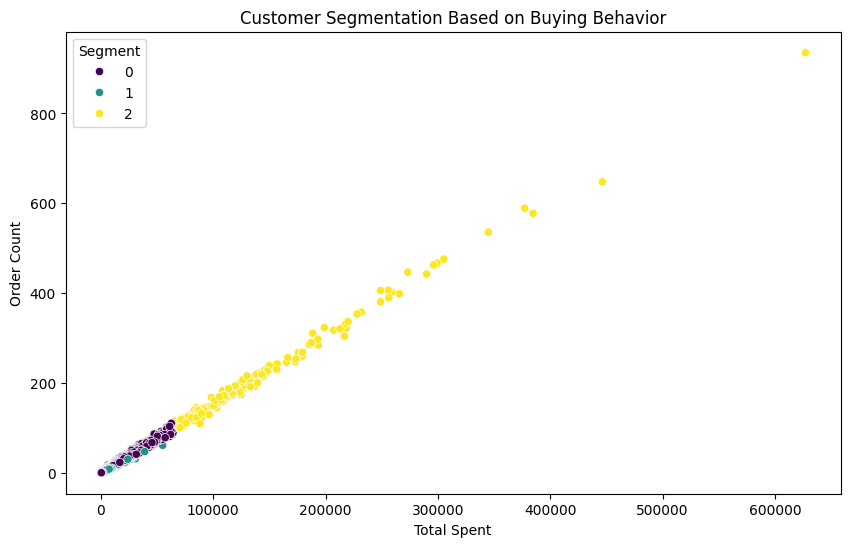

         ship-postal-code    total_spent  order_count  avg_order_value
Segment                                                               
0           527701.200278    6501.998334    10.416273       571.763238
1           511681.800868    3110.905246     3.630665       917.156270
2           407655.277487  128775.174712   197.937173       650.507453


In [21]:
df['Date'] = pd.to_datetime(df['Date'])  # Convert Date column to datetime

# Aggregate data by customer location (postal code)
customer_df = df.groupby(['ship-postal-code']).agg(
    total_spent=('Amount', 'sum'),  # Total revenue from each location
    order_count=('Order ID', 'nunique'),  # Unique orders placed
    avg_order_value=('Amount', 'mean')  # Average order value
).reset_index()

# Handle missing or invalid data
customer_df = customer_df.dropna()

# Standardize the features for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_df[['total_spent', 'order_count', 'avg_order_value']])

# Apply K-Means Clustering (3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
customer_df['Segment'] = kmeans.fit_predict(X_scaled)

# Visualize Segments
plt.figure(figsize=(10, 6))
sns.scatterplot(x=customer_df['total_spent'], y=customer_df['order_count'], hue=customer_df['Segment'], palette='viridis')
plt.xlabel('Total Spent')
plt.ylabel('Order Count')
plt.title('Customer Segmentation Based on Buying Behavior')
plt.show()

# Print segment characteristics
print(customer_df.groupby('Segment').mean())

I analyzed customer segments based on their shipping postal codes, total spending, order count, and average order value. Here's what I found:

Segment 0 (High Volume, Moderate Spending)

Customers in this segment have high order counts (~10.4 orders per customer).
Their total spending is around ₹527,701, but their average order value is lower at ₹571.76.
This suggests they frequently purchase lower-cost items, possibly indicating budget-conscious or bulk buyers.
Segment 1 (Low Order Count, High Order Value)

These customers place fewer orders (~3.63 per customer) but spend more per order (₹917.16 on average).
Their total spending is lower than Segment 0 (₹511,681), but they prefer higher-value products.
This could indicate premium buyers who focus on quality over quantity.
Segment 2 (High-Spending, Frequent Buyers)

This is the most valuable customer group, with a total spend of ₹407,655 per customer.
They make about 198 orders each, with an average order value of ₹650.50.
These customers are both highly engaged and high spenders, making them ideal for loyalty programs or targeted promotions.
Business Implications:
Segment 0: Target them with discounts on bulk purchases or subscription-based offers.
Segment 1: Offer premium products, exclusive deals, and personalized recommendations.
Segment 2: Focus on retaining these customers with loyalty programs, early access to new products, and VIP benefits.

### 5. Geographical Analysis:

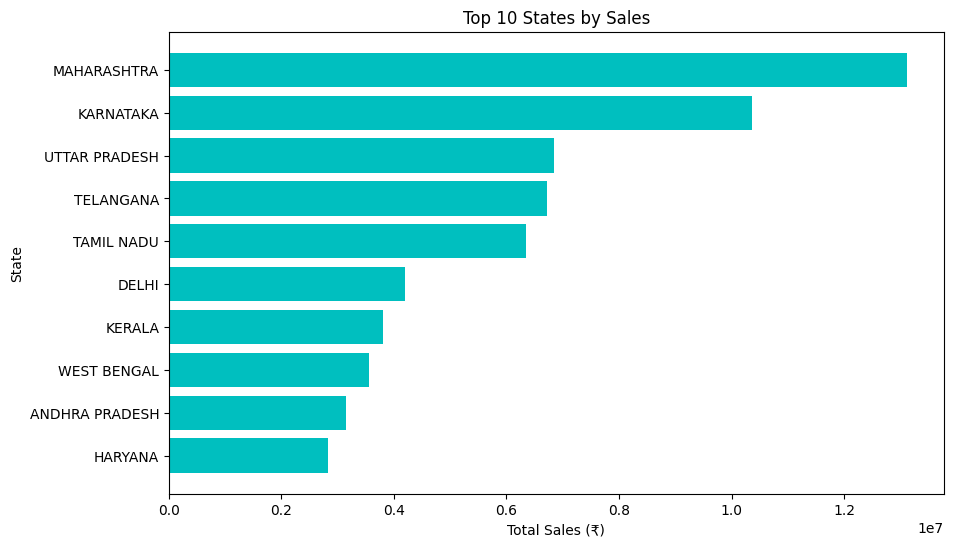

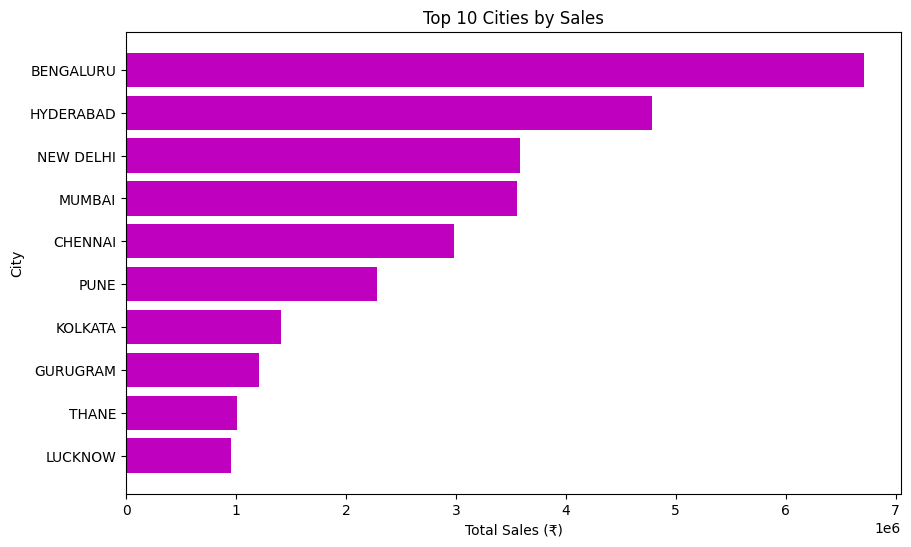

Top 5 States by Sales:
        ship-state  total_sales  total_orders
28    MAHARASHTRA  13118323.52         20756
23      KARNATAKA  10355613.10         16162
59  UTTAR PRADESH   6843625.88         10057
57      TELANGANA   6724083.99         10394
56     TAMIL NADU   6346334.37         10507

Top 5 Cities by Sales:
       ship-city  total_sales  total_orders
775   BENGALURU   6713356.87         10441
2904  HYDERABAD   4784105.00          7404
5391  NEW DELHI   3582051.62          5425
4793     MUMBAI   3556910.51          5645
1464    CHENNAI   2984677.09          4925


In [22]:
# Grouping sales by State and City
state_sales = df.groupby('ship-state').agg(
    total_sales=('Amount', 'sum'),
    total_orders=('Order ID', 'count')
).reset_index()

city_sales = df.groupby('ship-city').agg(
    total_sales=('Amount', 'sum'),
    total_orders=('Order ID', 'count')
).reset_index()

# Sorting by total sales
state_sales = state_sales.sort_values(by='total_sales', ascending=False)
city_sales = city_sales.sort_values(by='total_sales', ascending=False)

# Plot: Top 10 States by Sales
plt.figure(figsize=(10, 6))
plt.barh(state_sales['ship-state'][:10], state_sales['total_sales'][:10], color='c')
plt.xlabel('Total Sales (₹)')
plt.ylabel('State')
plt.title('Top 10 States by Sales')
plt.gca().invert_yaxis()
plt.show()

# Plot: Top 10 Cities by Sales
plt.figure(figsize=(10, 6))
plt.barh(city_sales['ship-city'][:10], city_sales['total_sales'][:10], color='m')
plt.xlabel('Total Sales (₹)')
plt.ylabel('City')
plt.title('Top 10 Cities by Sales')
plt.gca().invert_yaxis()
plt.show()

# Display top 5 states and cities
print("Top 5 States by Sales:\n", state_sales.head())
print("\nTop 5 Cities by Sales:\n", city_sales.head())


From the analysis, I observed that Maharashtra leads in total sales, followed by Karnataka, Uttar Pradesh, Telangana, and Tamil Nadu. These five states contribute significantly to overall revenue, indicating high consumer demand and a strong customer base in these regions.

State-wise Insights:
Maharashtra (₹13.1M, 20,756 orders) is the top-performing state, likely due to major urban hubs like Mumbai and Pune.
Karnataka (₹10.3M, 16,162 orders) follows, with Bengaluru being a key driver of sales.
Uttar Pradesh (₹6.8M, 10,057 orders) is a strong market despite being less urbanized, showing growing online shopping adoption.
Telangana (₹6.7M, 10,394 orders) and Tamil Nadu (₹6.3M, 10,507 orders) have comparable sales, indicating consistent demand in South India.
City-wise Insights:
Bengaluru (₹6.7M, 10,441 orders) leads, reflecting its high purchasing power and tech-savvy population.
Hyderabad (₹4.7M, 7,404 orders) follows closely, showing strong customer engagement.
New Delhi (₹3.5M, 5,425 orders) and Mumbai (₹3.5M, 5,645 orders) have similar sales volumes, reinforcing their status as major commercial hubs.
Chennai (₹2.9M, 4,925 orders) also contributes significantly, making South India a key sales region.
Key Takeaways:
Metro cities drive the highest sales, indicating a higher inclination towards online shopping.
Southern states (Karnataka, Tamil Nadu, Telangana) show strong revenue generation.
Uttar Pradesh’s presence in the top 5 suggests a rise in e-commerce adoption in non-metro regions.

### 6. Business Insights:

1. Sales & Product Performance
T-shirts and Shirts dominate sales, contributing the highest revenue and quantity sold. Recommendation: Stock popular sizes (M, L, XL) more and introduce targeted promotions.
Perfumes, Wallets, and Watches have low sales. Recommendation: Consider bundling them with high-selling products or running discounts to boost sales.
2. Fulfillment & Delivery
Amazon fulfills most orders (83.9k vs. 36.3k by Merchant), with a higher shipment success rate (86.5%). Recommendation: Prioritize Amazon fulfillment for better delivery efficiency and reduced cancellations.
Merchant fulfillment has higher "On the Way" orders (17.5%), indicating potential delays. Recommendation: Improve logistics or partner with faster courier services.
3. Geographical Trends
Maharashtra and Karnataka are top-performing states, with Bengaluru, Hyderabad, and New Delhi leading in city-wise sales. Recommendation: Focus more advertising and inventory allocation in these high-performing regions.
Expand marketing efforts in emerging markets like Uttar Pradesh and Telangana, where demand is rising.
4. Customer Segmentation & Behavior
High-spending customers (Segment 2) have an average order value of ₹917 but fewer orders. Recommendation: Implement a loyalty program or exclusive offers to encourage repeat purchases.
Mid-tier customers (Segment 1) make frequent purchases but spend moderately. Recommendation: Offer personalized discounts to increase basket size.
5. Inventory & Pricing Strategy
Large sizes (3XL, 6XL, 5XL) have lower sales compared to M, L, and XL. Recommendation: Reduce stock for less popular sizes and focus on fast-moving ones.
The average order value is ₹647. Recommendation: Introduce combo deals or upsell strategies to increase AOV.